In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix,
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.layers import  MaxPool2D
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.models import Sequential, Model
from keras.models import model_from_json
import pickle
import os
import matplotlib.pyplot as plt
# from django.core.files.storage import FileSystemStorage
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

global cnn_algorithm, X_train, X_test, y_train, y_test
X = np.load('/kaggle/input/hihihi/X.txt.npy')
Y = np.load('/kaggle/input/hihihi/Y.txt.npy')
X = X.astype('float32')
X = X/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation 
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output


In [4]:
num_classes = 10  

src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

classifier = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
classifier = Sequential()
            #defining convolution neural network layer with 32 layers to filter dataset features 32 times and then max pooling will collect all important features
classifier.add(Conv2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu'))
            #pooling layer to collect filtered features
classifier.add(MaxPool2D(pool_size = (2, 2)))
            #defining another layer with 32 filters
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPool2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(units = y_train.shape[1], activation = 'softmax'))
print(classifier.summary())
            #now compiling the model
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 256)               2

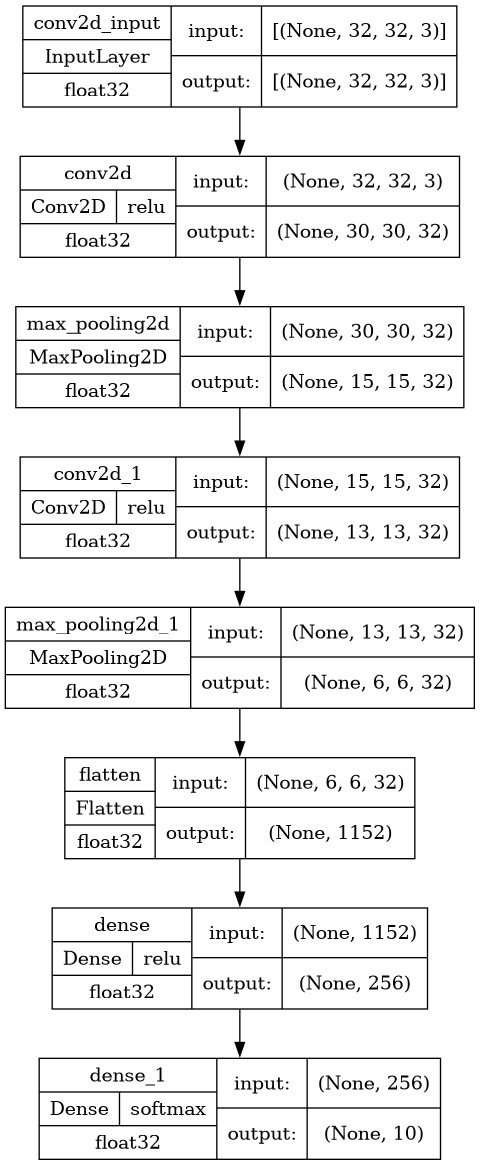

In [5]:
import tensorflow as tf
tf.keras.utils.plot_model(
    classifier,
    to_file="/kaggle/working/model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

In [6]:
from keras.callbacks import ModelCheckpoint

# ... Define and compile your model ...

# Define a ModelCheckpoint callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/model1_weights.h5',  # Path to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode for comparison (maximize the accuracy)
    verbose=1  # Print messages about the saving process
)
hist = classifier.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[model_checkpoint], verbose=2)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.53300, saving model to /kaggle/working/model1_weights.h5
1288/1288 - 13s - loss: 1.4505 - accuracy: 0.4821 - val_loss: 1.2755 - val_accuracy: 0.5330 - 13s/epoch - 10ms/step
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.53300 to 0.64402, saving model to /kaggle/working/model1_weights.h5
1288/1288 - 11s - loss: 1.1050 - accuracy: 0.6019 - val_loss: 0.9928 - val_accuracy: 0.6440 - 11s/epoch - 9ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.64402 to 0.65334, saving model to /kaggle/working/model1_weights.h5
1288/1288 - 11s - loss: 0.8997 - accuracy: 0.6702 - val_loss: 0.9819 - val_accuracy: 0.6533 - 11s/epoch - 9ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.65334 to 0.79697, saving model to /kaggle/working/model1_weights.h5
1288/1288 - 12s - loss: 0.6929 - accuracy: 0.7459 - val_loss: 0.5586 - val_accuracy: 0.7970 - 12s/epoch - 9ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.79697 to 0.84317, saving model to /kaggle/working/model1_weights.h5
1288/1288 - 11s - loss: 0.5014 - accuracy: 0.8168 - val_loss: 0.4305 - val_accuracy: 0.8432 - 11s/epoch - 9ms/step
Epoch 6/50

Epoch 6: val_accuracy improved from 0.84317 to 0.89208, saving mode

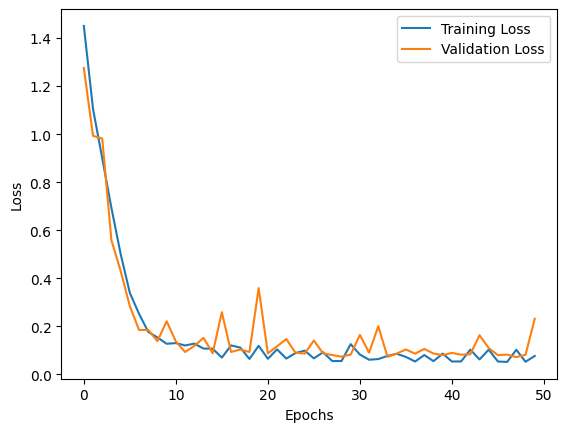

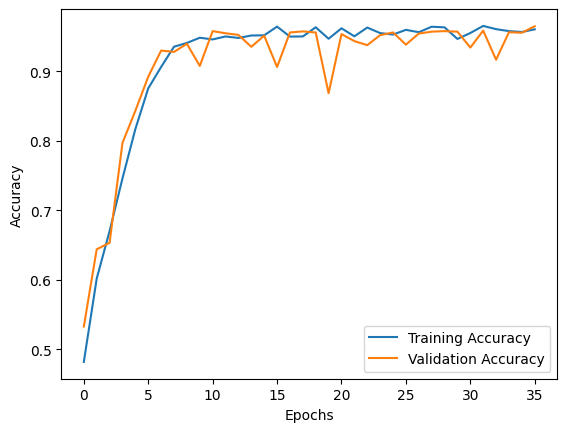

In [7]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy and val_accuracy curves up to the point where val_accuracy is maximum
max_val_accuracy_index = hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])) + 1
plt.plot(hist.history['accuracy'][:max_val_accuracy_index], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'][:max_val_accuracy_index], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
from keras.models import load_model
classifier = load_model('/kaggle/working/model1_weights.h5')

81/81 [==============================] - 1s 7ms/step


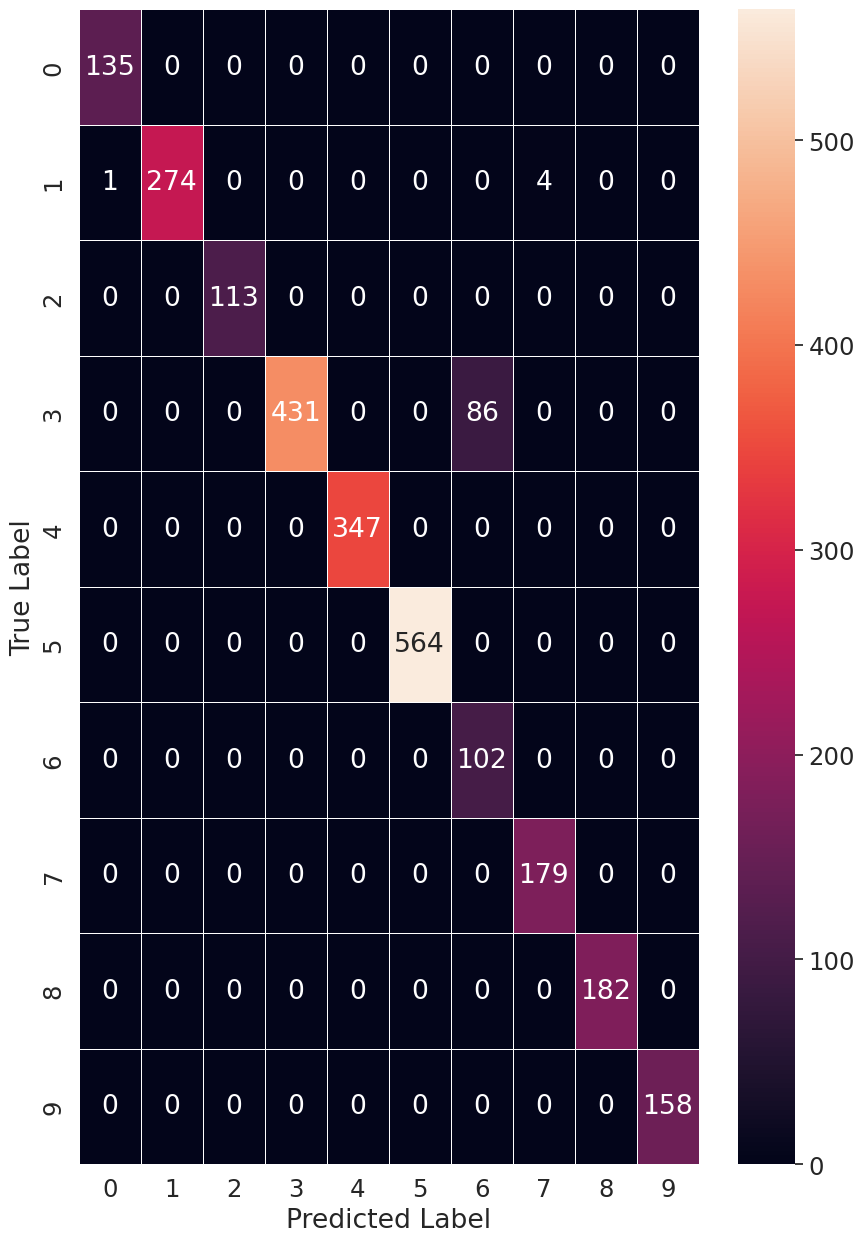

In [11]:
cnn_algorithm = classifier
y_pred = classifier.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
# Assuming cm, y_true, and y_pred_classes are defined
cm = confusion_matrix(y_true, y_pred_classes)
# Assuming cm, y_true, and y_pred_classes are defined

# Plot confusion matrix heatmap
fig, ax1= plt.subplots(1,1,figsize=(10,15))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax1,fmt='d')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
plt.show()

In [12]:
report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       135
           1       1.00      0.98      0.99       279
           2       1.00      1.00      1.00       113
           3       1.00      0.83      0.91       517
           4       1.00      1.00      1.00       347
           5       1.00      1.00      1.00       564
           6       0.54      1.00      0.70       102
           7       0.98      1.00      0.99       179
           8       1.00      1.00      1.00       182
           9       1.00      1.00      1.00       158

    accuracy                           0.96      2576
   macro avg       0.95      0.98      0.96      2576
weighted avg       0.98      0.96      0.97      2576

